In [1]:
%pylab inline
import pandas as pd
from pywsi.io import WSIReader
from pywsi.morphology import TissuePatch
from matplotlib.patches import Polygon

from shapely.geometry import Point as shapelyPoint
from shapely.geometry import box as shapely

from pywsi.io.operations import get_annotation_bounding_boxes, get_annotation_polygons, translate_and_scale_object
from pywsi.io.operations import translate_and_scale_polygon
from openslide.deepzoom import DeepZoomGenerator

import os
import glob
from skimage.filters import threshold_otsu
from skimage.color import rgb2gray
from shapely.geometry import Polygon as shapelyPolygon
import openslide

from tqdm import tqdm_notebook

from pywsi.io.operations import get_annotation_bounding_boxes, get_annotation_polygons, \
    poly2mask, translate_and_scale_polygon, read_as_rgb

from pywsi.morphology.patch_extractor import TissuePatch
from pywsi.morphology.mask import mpl_polygon_to_shapely_scaled, get_common_interior_polygons

from keras.models import Sequential
from keras.layers import Lambda, Dropout
from keras.layers.convolutional import Convolution2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.utils.np_utils import to_categorical
from sklearn.model_selection import StratifiedShuffleSplit

from pywsi.io.tiling import generate_tiles, get_all_patches_from_slide
import joblib
NUM_CLASSES = 2 # not_tumor, tumor
BATCH_SIZE = 32
JSON_DIR = '/Z/personal-folders/interns/saket/histopath_data/CAMELYON16/training/lesion_annotations_json/'

Populating the interactive namespace from numpy and matplotlib


Using TensorFlow backend.


In [2]:
model = Sequential()
model.add(Lambda(lambda x: x / 255.0 - 0.5, input_shape=(256, 256, 3)))
model.add(Convolution2D(100, (5, 5), strides=(2, 2), activation='elu', padding='same'))
model.add(MaxPooling2D())
model.add(Convolution2D(200, (5, 5), strides=(2, 2), activation='elu', padding='same'))
model.add(MaxPooling2D())
model.add(Convolution2D(300, (3, 3), activation='elu', padding='same'))
model.add(Convolution2D(400, (3, 3), activation='elu',  padding='same'))
model.add(Dropout(0.1))
model.add(Convolution2D(400, (3, 3), activation='elu',  padding='same'))
model.add(Convolution2D(300, (3, 3), activation='elu',  padding='same'))
model.add(Dropout(0.1))
model.add(Convolution2D(2, (1, 1))) # this is called upscore layer for some reason?
model.add(Conv2DTranspose(2, (31, 31), strides=(16, 16), activation='softmax', padding='same'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [3]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_1 (Lambda)            (None, 256, 256, 3)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 128, 100)     7600      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 64, 64, 100)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 200)       500200    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 16, 16, 200)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 300)       540300    
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 16, 16, 400)       1080400   
__________

# Get slides


In [4]:
def get_corrected_tumor_mask(polygons, thumbnail_nrow, thumbnail_ncol):
    scaled_tumor_polygons = []
    for tpol in polygons['tumor']:
        scaled = translate_and_scale_polygon(tpol, 0, 0, 1/256)
        scaled_tumor_polygons.append(scaled)
    polymasked = poly2mask(scaled_tumor_polygons, (thumbnail_nrow, thumbnail_ncol))
    # Is any of the masked out points inside a normal annotated region?
    poly_x, poly_y = np.where(polymasked > 0)
    set_to_zero = [] 
    for px, py in zip(poly_x, poly_y):
        point = shapelyPoint(px, py)
        for npol in polygons['normal']:
            scaled = translate_and_scale_polygon(npol, 0, 0, 1/256)
            pol = shapelyPolygon(scaled.get_xy())
            if pol.contains(point):
                set_to_zero.append((px,py))

    if len(set_to_zero):
        set_to_zero = np.array(set_to_zero)
        polymasked[set_to_zero] = 0        
    return polymasked

def create_tumor_mask_from_tile(tile_x, tile_y, polygons, patch_size=256):
    """Create a patch_size x patch_size mask from tile_x,y coordinates
    Parameters
    ----------
    tile_x, tile_y:  int
    polygons: dict
              ['normal', 'tumor'] with corresponding polygons
    
    Returns
    -------
    mask: array
          patch_size x patch_size binary mask
    
    """
    
    # Initiate a zero mask
    mask = np.zeros((patch_size, patch_size))    
    #patch_polygon = shapelyRectangle(tile_x, tile_y, patch_size, patch_size)
    x_min = tile_x
    y_min = tile_y
    x_max = x_min + 256
    y_max = y_min + 256
    patch_polygon = shapelyPolygon([(x_min, y_min), (x_max, y_min),
                                    (x_max, y_max), (x_min, y_max)])

    #print(list(patch_polygon.boundary.coords))
    #for poly in polygons['tumor']:
    #    print(list(poly.boundary.coords))
    
    # Is it overlapping any of the tumor polygons?
    ## is_inside_tumor = get_common_interior_polygons(patch_polygon, polygons['tumor'])
    #is_inside_tumor = [polygon.buffer(0).contains(patch_polygon) for polygon in polygons['tumor']]
    is_inside_tumor = [patch_polygon.intersection(polygon.buffer(0)) for polygon in polygons['tumor']]
   
    # the patch will always be inside just one annotated boundary
    # which are assumed to be non-overlapping and hence we can just fetch
    # the first sample
    tumor_poly_index = None
    tumor_poly_coords = None
    for index, sample_intersection in enumerate(is_inside_tumor):
        if sample_intersection.area > 0 and sample_intersection.is_valid:
            tumor_poly_index = index
            if sample_intersection.geom_type == 'Polygon':
                tumor_poly_coords = np.array(sample_intersection.boundary.coords)
            elif sample_intersection.geom_type == 'MultiPolygon':
                tumor_poly_coords = []
                for p in sample_intersection:
                    tumor_poly_coords += p.boundary.coords
                tumor_poly_coords = np.array(tumor_poly_coords)
            elif sample_intersection.geom_type == 'GeometryCollection':
                tumor_poly_coords = []
                for p in sample_intersection:
                    if p.geom_type == 'LineString' or p.geom_type=='Point':
                        tumor_poly_coords += p.coords
                    elif p.geom_type == 'Polygon':
                        tumor_poly_coords += p.boundary.coords
                    else:
                        print('Found geom_type:{}'.format(p.geom_type))
                        raise ValueError('')
                tumor_poly_coords = np.array(tumor_poly_coords)
                
            else:
                print('Found geom_type:{}'.format(sample_intersection.geom_type))
                raise ValueError('')
            break
            
    if tumor_poly_index is None:
        # No overlap with tumor so must return as is
        return mask
    
    # This path belongs to a tumor patch so set everything to one
    # Set these coordinates to one
    # FIX: keep the start from zero only
    ##mask = np.ones((patch_size, patch_size))    
    # Create a polygon of these coordinates
    
    # Shift the tumor coordinates to tile_x, tile_y
    tumor_poly_coords = tumor_poly_coords - np.array([tile_x, tile_y])
    overlapping_tumor_poly = shapelyPolygon(tumor_poly_coords)
    # Create a psuedo mask
    #print(tumor_poly_index, tumor_poly_coords)
    #print(overlapping_tumor_poly.boundary.coords, tumor_poly_coords)
    #try:
    psuedo_mask = poly2mask([overlapping_tumor_poly], (patch_size, patch_size))
    #except:
    #    raise ValueError('{} | {}'.format(overlapping_tumor_poly.exterior, 
    #                                      overlapping_tumor_poly.boundary.coords))
    # Add it to the original mask
    mask = np.logical_or(mask, psuedo_mask)

    # If its inside tumor does this tumor patch actually contain any normal patches?
    tumor_poly = polygons['tumor'][tumor_poly_index]
    normal_patches_inside_tumor = get_common_interior_polygons(tumor_poly, polygons['normal'])

    # For all the normal patches, ensure 
    # we set the mask to zero
    for index in normal_patches_inside_tumor:
        normal_poly = polygons['normal'][index]

        # What is the intersection portion of this normal polygon
        # with our patch of interest?
        common_area = normal_poly.intersection(patch_polygon)
        if common_area:
            normal_poly_coords = np.array(common_area.boundary.coords) - np.array([tile_x, tile_y])          
            overlapping_normal_poly = shapelyPolygon(normal_poly_coords)
            psuedo_mask = poly2mask([overlapping_normal_poly], (patch_size, patch_size))
            # Get coordinates wherever this is non zero
            non_zero_coords = np.where(psuedo_mask > 0)
            # Add set these explicitly to zer
            mask[non_zero_coords] = 0
    return mask

    

def find_patches_from_slide(slide_path, polygons, 
                            add_tumor_patches=True, filter_non_tissue=True):
    """Returns a dataframe of all patches in slide
    input: slide_path: path to WSI file
    output: samples: dataframe with the following columns:
        slide_path: path of slide
        is_tissue: sample contains tissue
        is_tumor: truth status of sample
        tile_loc: coordinates of samples in slide
        
    
    option: base_truth_dir: directory of truth slides
    option: filter_non_tissue: Remove samples no tissue detected
    """
    slide_contains_tumor = False#'tumor' in os.path.basename(slide_path)
    
    with openslide.open_slide(slide_path) as slide:
        thumbnail = slide.get_thumbnail((int(slide.dimensions[0] / 256), int(slide.dimensions[1] / 256)))
        thumbnail_nrow = int(slide.dimensions[0] / 256)
        thumbnail_ncol = int(slide.dimensions[1] / 256)
    
    thumbnail_grey = np.array(thumbnail.convert('L')) # convert to grayscale
    
    thresh = threshold_otsu(thumbnail_grey)
    binary = thumbnail_grey > thresh
    
    patches = pd.DataFrame(pd.DataFrame(binary).stack())
    patches.loc[:, 'is_tissue'] = ~patches[0]
    patches.drop(0, axis=1, inplace=True)
    
    if add_tumor_patches:
        polymasked = get_corrected_tumor_mask(polygons, thumbnail_nrow, thumbnail_ncol)
                
        patches_y = pd.DataFrame(pd.DataFrame(polymasked).stack())
        patches_y['is_tumor'] = patches_y[0] > 0
        patches_y.drop(0, axis=1, inplace=True)

        patches = pd.concat([patches, patches_y], axis=1)
        
    patches.loc[:, 'sample'] = os.path.basename(slide_path).replace('.tif', '')
    patches.loc[:, 'slide_path'] = slide_path
    if filter_non_tissue:
        patches = patches[patches.is_tissue == True] # remove patches with no tissue
    patches['tile_loc'] = list(patches.index)
    patches.reset_index(inplace=True, drop=True)
    return patches

In [5]:
def gen_imgs(samples, batch_size, shuffle=True):
    """This function returns a generator that 
    yields tuples of (
        X: tensor, float - [batch_size, 256, 256, 3]
        y: tensor, int32 - [batch_size, 256, 256, NUM_CLASSES]
    )
    
    
    input: samples: samples dataframe
    input: batch_size: The number of images to return for each pull
    output: yield (X_train, y_train): generator of X, y tensors
    
    option: base_truth_dir: path, directory of truth slides
    option: shuffle: bool, if True shuffle samples
    """
    
    num_samples = len(samples)
    while 1: # Loop forever so the generator never terminates
        if shuffle:
            samples = samples.sample(frac=1) # shuffle samples
        
        for offset in range(0, num_samples, batch_size):
            batch_samples = samples.iloc[offset:offset+batch_size]
        
            images = []
            masks = []
            for _, batch_sample in batch_samples.iterrows():
                slide_contains_tumor = batch_sample['sample'].startswith('tumor')
                
                with openslide.open_slide(batch_sample.slide_path) as slide:
                    tiles = DeepZoomGenerator(slide, tile_size=256, overlap=0, limit_bounds=False)
                    # the get_tile tuple required is (col, row)
                    img = tiles.get_tile(tiles.level_count-1, batch_sample.tile_loc[::-1])
                    (tile_x, tile_y), tile_level, _ = tiles.get_tile_coordinates(tiles.level_count-1, 
                                                                               batch_sample.tile_loc[::-1])
                    
                    
                # only load truth mask for tumor slides
                if slide_contains_tumor:
                    #mask = np.ones((256, 256))
                    
                    
                    json_filepath = os.path.join(JSON_DIR, batch_sample['sample']+'.json')
                    polygons = get_annotation_polygons(json_filepath, 'shapely')                    
                    
                    mask = create_tumor_mask_from_tile(tile_x, tile_y, polygons, 256)
                    """
                    x_min = tile_x
                    y_min = tile_y
                    x_max = x_min + 256
                    y_max = y_min + 256
                    patch_polygon = shapelyPolygon([(x_min, y_min), (x_max, y_min),
                                                    (x_max, y_max), (x_min, y_max)])
                    is_inside_tumor = get_common_interior_polygons(patch_polygon, polygons['tumor'])
                    if len(is_inside_tumor):
                        #mask = np.ones((256, 256))
                        print('is_inside_tumor: {}'.format(is_inside_tumor))
                    else:
                        #mask = np.zeros((256, 256))
                        pass
                    
                    
                    
                        # is any of the marked spot inside a normal patch?
                        set_to_zero = []
                        poly_x, poly_y = np.where(mask > 0)
                        for px, py in zip(poly_x, poly_y):
                            point = shapelyPoint(px+tile_x, py+tile_y)
                            for npol in polygons['normal']:                                
                                pol = shapelyPolygon(npol.get_xy())
                                if pol.contains(point):
                                    set_to_zero.append((px, py)) 
                        print('Set to zero: {}'.format(len(set_to_zero)))
                        if len(set_to_zero):
                            mask[np.array(set_to_zero)] = 0
                            
                    
                    else:
                        mask = np.zeros((256, 256))
                    """
                    # is any of the unmakred spot inside a cancerous patch?
                    # TODO?
                    
                else:
                    mask = np.zeros((256, 256))

                images.append(np.array(img))
                masks.append(mask)

            X_train = np.array(images)
            y_train = np.array(masks)
            y_train = to_categorical(y_train, num_classes=2).reshape(y_train.shape[0], 256, 256, 2)
            yield X_train, y_train

In [6]:
slide_path = '../../../histopath_data/CAMELYON16/training/tumor/tumor_110.tif'
json_filepath = '../../../histopath_data/CAMELYON16/training/lesion_annotations_json/tumor_110.json'

boxes = get_annotation_bounding_boxes(json_filepath)
polygons = get_annotation_polygons(json_filepath)
samples = find_patches_from_slide(slide_path, polygons, add_tumor_patches=True, filter_non_tissue=True) 

In [7]:
sample_gen = gen_imgs(samples.sample(32, random_state=42), 32, shuffle=False)


In [8]:
example_X, example_y  = next(sample_gen)

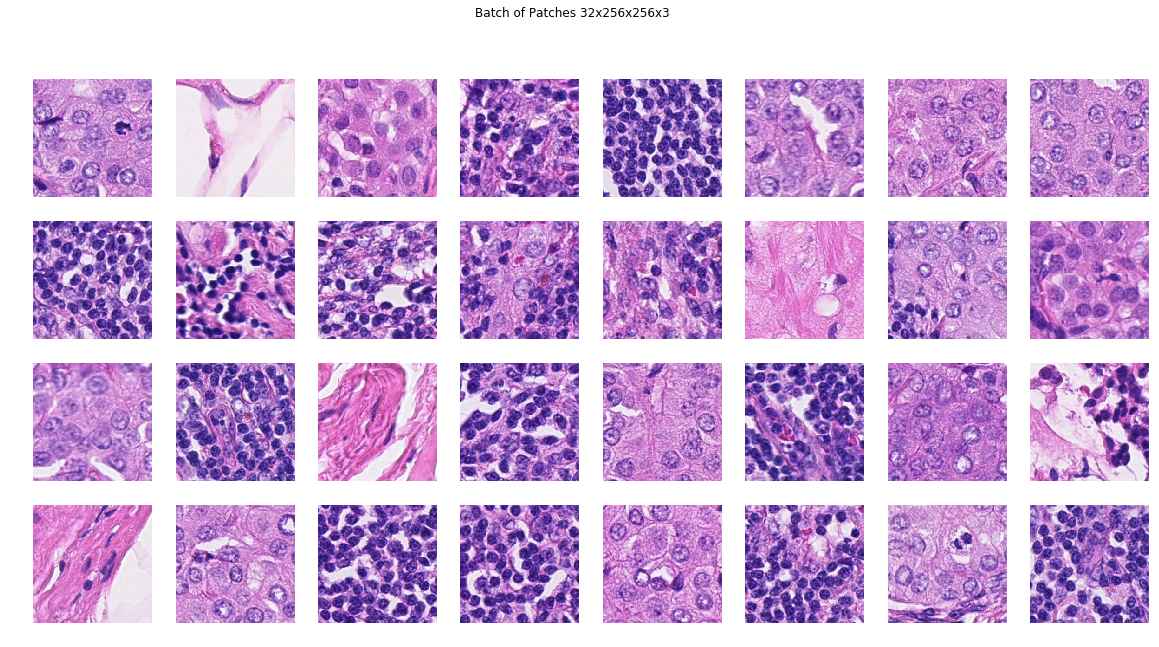

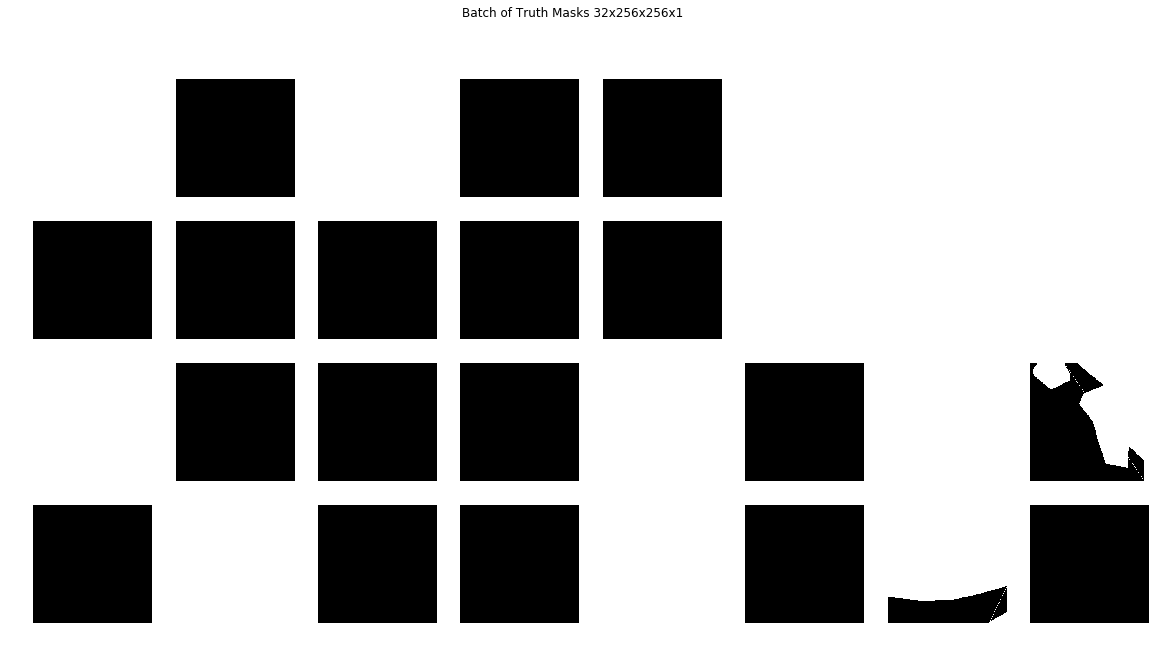

In [9]:
f, axes = plt.subplots(4, 8, figsize=(20, 10));
ax = axes.flatten()
for i in range(0, example_X.shape[0]):
    _ = ax[i].imshow(example_X[i]);
    _ = ax[i].axis('off');
f.suptitle('Batch of Patches 32x256x256x3');
    
f, axes = plt.subplots(4, 8, figsize=(20, 10));
ax = axes.flatten()    
for i in range(0, example_X.shape[0]):
    _ = ax[i].imshow(example_y[i].argmax(axis=2), cmap='gray', vmin=0, vmax=1);
    _ = ax[i].axis('off');
f.suptitle('Batch of Truth Masks 32x256x256x1');

In [10]:
BATCH_SIZE = 32
N_EPOCHS = 50

NUM_SAMPLES = 10000

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(samples, samples["is_tumor"]):
    train_samples = samples.loc[train_index]
    validation_samples = samples.loc[test_index]

In [11]:
train_generator = gen_imgs(train_samples, BATCH_SIZE)
validation_generator = gen_imgs(validation_samples, BATCH_SIZE)

In [12]:
filepath = "weights-improvement-{epoch:02d}-{val_acc:.2f}.hdf"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

model.fit_generator(train_generator, 
                    np.ceil(len(train_samples) / BATCH_SIZE),
                    validation_data=validation_generator,
                    validation_steps=np.ceil(len(validation_samples) / BATCH_SIZE),
                    epochs=N_EPOCHS, 
                    callbacks=callbacks_list)



Epoch 1/50
800/800 [==============================] - 3674s 5s/step - loss: 0.2068 - acc: 0.9257 - val_loss: 0.1395 - val_acc: 0.9557

Epoch 00001: val_acc improved from -inf to 0.95571, saving model to weights-improvement-01-0.96.hdf
Epoch 2/50
800/800 [==============================] - 3688s 5s/step - loss: 0.1245 - acc: 0.9594 - val_loss: 0.1200 - val_acc: 0.9581

Epoch 00002: val_acc improved from 0.95571 to 0.95812, saving model to weights-improvement-02-0.96.hdf
Epoch 3/50
800/800 [==============================] - 3623s 5s/step - loss: 0.1102 - acc: 0.9649 - val_loss: 0.1092 - val_acc: 0.9674

Epoch 00003: val_acc improved from 0.95812 to 0.96739, saving model to weights-improvement-03-0.97.hdf
Epoch 4/50
800/800 [==============================] - 3588s 4s/step - loss: 0.1023 - acc: 0.9671 - val_loss: 0.1002 - val_acc: 0.9690

Epoch 00004: val_acc improved from 0.96739 to 0.96901, saving model to weights-improvement-04-0.97.hdf
Epoch 5/50
800/800 [==============================]

KeyboardInterrupt: 

In [14]:
model.save('keras_model_improved_4Mparams.h5')


In [15]:
def predict_from_model(patch, model):
    """Predict which pixels are tumor.
    
    input: patch: 256x256x3, rgb image
    input: model: keras model
    output: prediction: 256x256x1, per-pixel tumor probability
    """
    
    prediction = model.predict(patch.reshape(1, 256, 256, 3))
    prediction = prediction[:, :, :, 1].reshape(256, 256)
    return prediction

In [16]:
import matplotlib.gridspec as gridspec

def plot_blend(patch, prediction, ax, alpha=0.75):
    """alpha blend patch and prediction.
    https://matplotlib.org/examples/pylab_examples/layer_images.html
    
    input: patch: 256x256x3, rgb image
    input: prediction: 256x256x1, per-pixel tumor probability
    input: ax: maplotlib Axes object
    input: alpha: alpha blend
    """
    
    dx, dy = 0.05, 0.05
    x = np.arange(0, patch.shape[1] - 1, dx)
    y = np.arange(0, patch.shape[0] - 1, dy)
    xmin, xmax, ymin, ymax = np.amin(x), np.amax(x), np.amin(y), np.amax(y)
    extent = xmin, xmax, ymin, ymax

    # fig = plt.figure(frameon=False, figsize=(10, 5))
    Z1 = rgb2gray(patch)
    Z2 = prediction

    im1 = ax.imshow(Z1, cmap='gray', extent=extent)
    im2 = ax.imshow(Z2, cmap='viridis', alpha=alpha, vmin=0.0, vmax=1.0,
                     extent=extent)
    ax.axis('off');

def plot_patch_with_pred(patch, truth, prediction, title_str='', alpha=0.6):
    """
    input: patch: 256x256x3, rgb image
    input: truth: 256x256x2, onehot output classes (not_tumor, tumor)
    input: prediction: 256x256x1, per-pixel tumor probability
    """
    gs = gridspec.GridSpec(2, 4, width_ratios=[10, 10, 19, 1])
    ax0 = plt.subplot(gs[0, 0])
    ax1 = plt.subplot(gs[0, 1])
    ax2 = plt.subplot(gs[1, 0])
    ax3 = plt.subplot(gs[1, 1])
    ax4 = plt.subplot(gs[:, 2])
    axc = plt.subplot(gs[:, 3])

    ax0.imshow(patch);
    ax0.set_title('Original')
    
    ax1.imshow(truth.argmax(axis=2), cmap='gray', vmin=0, vmax=1);
    ax1.set_title('Truth mask (white=tumor, black=not_tumor)')
    
    p = ax2.imshow(prediction, cmap='viridis', vmin=0, vmax=1);
    ax2.set_title('Prediction heatmap')

    ax3.imshow((prediction > 0.5).astype(np.int), cmap='gray', vmin=0, vmax=1);
    ax3.set_title('Prediction mask (white=tumor, black=not_tumor)')
    
    plot_blend(patch, prediction, ax4, alpha)
    ax4.set_title('Original+Prediction blend')
    
    fig = plt.gcf()
    fig.set_size_inches(20, 10)
    fig.suptitle(title_str)
    fig.colorbar(p, cax=axc, orientation="vertical")
    axc.set_title('Probability pixel is tumor')
    

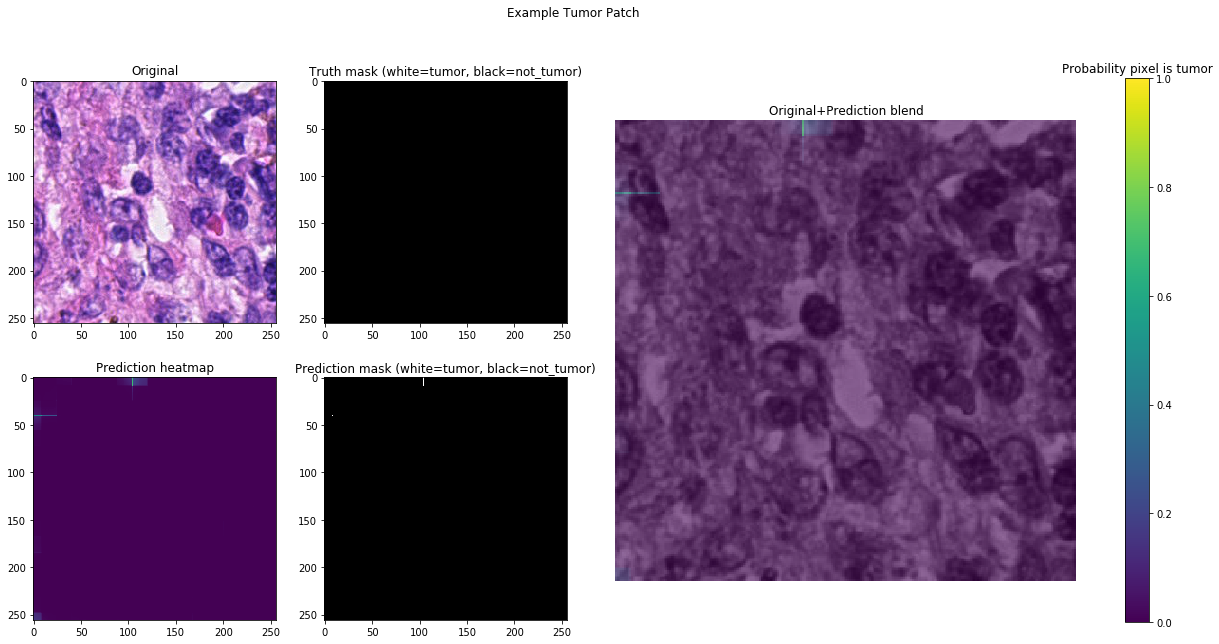

In [19]:
example_patch = example_X[12]
example_truth = example_y[12]

prediction = predict_from_model(example_patch, model)
plot_patch_with_pred(example_patch, example_truth, prediction, title_str='Example Tumor Patch')
#plt.savefig('unknown_sample.png')

In [ ]:
from sklearn.metrics import confusion_matrix
from tqdm import tqdm

def predict_batch_from_model(patches, model):
    """Predict which pixels are tumor.
    
    input: patch: `batch_size`x256x256x3, rgb image
    input: model: keras model
    output: prediction: 256x256x1, per-pixel tumor probability
    """
    predictions = model.predict(patches)
    predictions = predictions[:, :, :, 1]
    return predictions

validation_generator = gen_imgs(validation_samples, BATCH_SIZE)
validation_steps = np.ceil(len(validation_samples) / BATCH_SIZE)

confusion_mtx = np.zeros((2, 2))

for i in tqdm(range(int(validation_steps))):
    X, y  = next(validation_generator)
    preds = predict_batch_from_model(X, model)
    
    y_true = y[:, :, :, 1].ravel()
    y_pred = np.uint8(preds > 0.5).ravel()
    
    confusion_mtx += confusion_matrix(y_true, y_pred, labels=[0, 1])

In [1]:
output_dir = '/Z/personal-folders/interns/saket/histopath_data/prediction_heatmaps/tumor_001'
os.makedirs(output_dir, exist_ok=True)

alpha = 0.5
slide_path = '/Z/personal-folders/interns/saket/histopath_data/CAMELYON16/training/tumor/tumor_001.tif'
json_filepath = '/Z/personal-folders/interns/saket/histopath_data/CAMELYON16/training/lesion_annotations_json/tumor_001.json'
all_samples = get_all_patches_from_slide(slide_path, json_filepath, False, 256)
slide = WSIReader(slide_path, 40)

n_samples = len(all_samples)
n_cols = int(slide.dimensions[0] / 256)
n_rows = int(slide.dimensions[1] / 256)
#assert n_cols * n_rows == n_samples

thumbnail = slide.get_thumbnail((n_cols, n_rows))
thumbnail = np.array(thumbnail)

# batch_size = n_cols
batch_size = 32
output_thumbnail_preds = list()
    
for offset in tqdm_notebook(list(range(0, n_samples, batch_size))):
    batch_samples = all_samples.iloc[offset:offset+batch_size]
    #batch_samples.loc[: 'tile_loc'] = [eval(x) for x in batch_samples.tile_loc]
    png_fnames = batch_samples.tile_loc.apply(lambda coord: os.path.join(output_dir,
                                                                         '{}_{}.png'.format(coord[1], coord[0])))
    
    X, _ = next(generate_tiles(batch_samples, batch_size, shuffle=False))
    
    if batch_samples.is_tissue.nunique() == 1 and batch_samples.iloc[0].is_tissue == False:
        # all patches in this row do not have tissue, skip them all
        output_thumbnail_preds.append(np.zeros(batch_size, dtype=np.float32))
        
        # output pngs
        for i, png_fname in enumerate(png_fnames):
            plt.imsave(png_fname, X[i])
    else:
        # make predictions
        preds = predict_batch_from_model(X, model)
        output_thumbnail_preds.append(preds.mean(axis=(1,2)))
        
        # overlay preds
        # save blended imgs
        for i, png_fname in enumerate(png_fnames):
            pred_i = preds[i]
            X_i = X[i]
            #output_img = rgb2gray(X_i)
            #output_img2 = gray2rgb(output_img.copy())

            #overlay = np.uint8(cm.viridis(pred_i) * 255)[:,:,:3]
            #blended = overlay*alpha + output_img2 *(1-alpha) +  0
            output_img = cv2.cvtColor(X_i, cv2.COLOR_RGB2GRAY)
            output_img2 = cv2.cvtColor(output_img.copy(), cv2.COLOR_GRAY2RGB)

            overlay = np.uint8(cm.viridis(pred_i) * 255)[:,:,:3]
            blended = cv2.addWeighted(overlay, alpha, output_img2, 1-alpha, 0, output_img)
            #blended = overlay*alpha + output_img2 *(1-alpha) +  0
            #blended = np.clip(blended, 0, 255)
            plt.imsave(png_fname, blended)
        

output_thumbnail_preds = np.array(output_thumbnail_preds)

NameError: name 'os' is not defined

In [2]:
 x = joblib.load('/Z/personal-folders/interns/saket/github/pywsi/data/patch_img_and_mask/train_df/tumor_076_157_171.img.joblib.pickle')

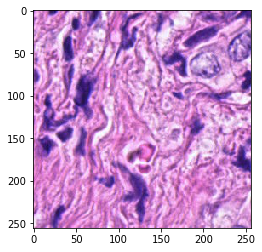

In [3]:
plt.imshow(x)

In [4]:
x

array([[[145,  71, 170],
        [178, 103, 204],
        [217, 143, 240],
        ...,
        [ 68,  30, 141],
        [ 65,  28, 133],
        [ 65,  29, 129]],

       [[152,  81, 177],
        [185, 113, 212],
        [222, 148, 243],
        ...,
        [ 79,  38, 144],
        [ 79,  38, 140],
        [ 81,  41, 137]],

       [[163,  93, 182],
        [196, 125, 219],
        [224, 153, 245],
        ...,
        [ 81,  34, 138],
        [ 81,  35, 133],
        [ 82,  37, 130]],

       ...,

       [[254, 229, 255],
        [255, 226, 254],
        [255, 222, 249],
        ...,
        [225, 163, 228],
        [207, 145, 212],
        [204, 141, 211]],

       [[252, 215, 248],
        [246, 202, 235],
        [234, 182, 218],
        ...,
        [227, 162, 230],
        [215, 148, 215],
        [215, 148, 215]],

       [[241, 195, 231],
        [220, 170, 205],
        [191, 133, 171],
        ...,
        [224, 157, 228],
        [218, 149, 216],
        [220, 150, 213]]

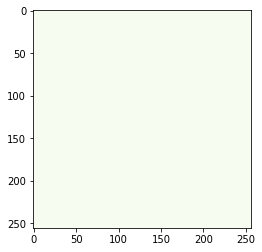

In [16]:
x1 = joblib.load('/Z/personal-folders/interns/saket/github/pywsi/data/patch_img_and_mask/train_df/tumor_076_157_171.mask.joblib.pickle')
plt.imshow(256*x1, cmap='GnBu', interpolation='nearest')

In [11]:
x1

array([[ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       ...,
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True]])